In [ ]:
# Reference
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

#Lab 1-2/3. Quantization-aware training**

In [ ]:
from google.colab import drive
import os
drive.mount('/drive')
wdir = './'
if os.path.exists(wdir) == False:
  os.mkdir(wdir)

Mounted at /drive


In [ ]:
# %matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

**1. Load dataset**

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 3

# Your code: load dataset
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = 1)

testset = torchvision.datasets.MNIST(root = './data',
                                     train = False,
                                     download = True,
                                     transform = transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         num_workers = 1)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
print([len(trainloader), len(testloader)])

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]

[20000, 3334]


In [ ]:
print([len(trainloader), len(testloader)])

[20000, 3334]


In [ ]:
image, label = trainset[0]
image.shape, label

(torch.Size([1, 28, 28]), 5)

torch.Size([3, 1, 28, 28])
tensor([2, 9, 7])


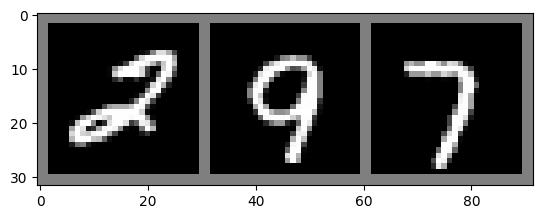

2     9     7    


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print Shape of the image
print(f'{images.shape}')
print(f'{labels}')

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

##2. Define neural network**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 2-1. Quantization model

In [ ]:
from torch.autograd.function import InplaceFunction

# Your code: quantization

def clip(input, qbit):
  max_value = 2. ** (qbit-1) -1.
  min_value = -2. ** (qbit-1)
  output = torch.clip(input, min_value, max_value)
  return output

class UniformQuantize(InplaceFunction):
  @classmethod
  def forward(cls, ctx, input, qbit):
    # Get Min/Max value of tensor (Min- Max quantization)
    min_value = float(input.min())
    max_value = float(input.max())
    abs_min_value = abs(min_value)
    abs_max_value = abs(max_value)
    # Get Max, Min condition
    if(abs_max_value >= abs_min_value):
      min_cond = -abs_max_value
      max_cond = abs_max_value
    else:
      min_cond = -abs_min_value
      max_cond = abs_min_value
    # Get Scale that is fit with INT8
    qmin = 0.
    qmax = 2.**qbit - 1.
    scale = (max_cond - min_cond) / (qmax - qmin)
    # Divide by scale and make into integer(Real Quantize)
    output = input / scale
    output.floor_()
    # Quantize and clip
    output = clip(input = output, qbit = qbit)
    # Dequantize
    output.mul_(scale)
    return output

  @staticmethod
  def backward(ctx, grad_output):
    # Straight-Through Estimator
    grad_input = grad_output
    return grad_input, None, None, None, None, None, None

In [ ]:
def quant_minmax(input, qbit):
  return UniformQuantize().apply(input, qbit)

class QLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias = False, quantize = False, bita = 8, bitw = 8):
    super().__init__(in_features, out_features, bias = bias)
    self.in_features = in_features
    self.out_features = out_features
    self._bias = bias

    self.quantize = quantize
    self.bita = bita
    self.bitw = bitw

  def forward(self, input):
    if self.quantize:
      Qinput = quant_minmax(input, qbit = self.bita)
      Qweight = quant_minmax(self.weight, qbit = self.bitw)
    else:
      Qinput = input
      Qweight = self.weight
    if self._bias:
      return F.linear(input = Qinput, weight = Qweight, bias = self.bias)
    else:
      return F.linear(input = Qinput, weight = Qweight, bias = None)

### 2-2. Quantization Model(2)

In [ ]:
class Net(nn.Module):
    # Your code: define neural network
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            QLinear(28 * 28, 128, bias = False, quantize = True, bita = 8, bitw = 8),
            nn.ReLU(),
            QLinear(128, 10, bias = False, quantize = True, bita = 8, bitw = 8)
        )

    def forward(self, x):
      x = self.layer_stack(x)
      return x

net = Net()

##3. Define loss function and optimizer**

In [ ]:
import torch.optim as optim

# Your code: define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

##4. Set GPU**

In [ ]:
# Your code: Set GPU(Device agnostic code)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

net.to(device)
print(net)

cuda:0
Net(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): QLinear(in_features=784, out_features=128, bias=False)
    (2): ReLU()
    (3): QLinear(in_features=128, out_features=10, bias=False)
  )
)


##5. Train neural network**

In [ ]:
# Your code: Train neural network

# Set the number of epochs
epochs = 2

for epoch in range(epochs): # Loop over the dataset multiple times
  print(f"Epoch: {epoch}\n-----")
  ### Training
  train_loss = 0

  # Set Train Mode
  net.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(trainloader):

    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = net(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train_loss

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    if batch % 2000 == 1999: # Print out every 2000 mini-batches
      print(f'[{epoch + 1}, {batch + 1 : 5d}], loss : {train_loss / 2000 :.3f}')
      train_loss = 0

print('Finished Training')

Epoch: 0
-----
[1,  2000], loss : 0.684
[1,  4000], loss : 0.403
[1,  6000], loss : 0.334
[1,  8000], loss : 0.279
[1,  10000], loss : 0.255
[1,  12000], loss : 0.258
[1,  14000], loss : 0.217
[1,  16000], loss : 0.223
[1,  18000], loss : 0.199
[1,  20000], loss : 0.199
Epoch: 1
-----
[2,  2000], loss : 0.161
[2,  4000], loss : 0.164
[2,  6000], loss : 0.169
[2,  8000], loss : 0.146
[2,  10000], loss : 0.151
[2,  12000], loss : 0.156
[2,  14000], loss : 0.163
[2,  16000], loss : 0.153
[2,  18000], loss : 0.133
[2,  20000], loss : 0.131
Finished Training


##6. Save trained model and test accuracy**

In [ ]:
# Your code: Save trained model
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model file path
MODEL_NAME = "mnist_net.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = net.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/mnist_net.pth


In [ ]:
def accuracy_fn(y_true, y_pred):
  accuracy = torch.eq(y_true, y_pred).sum().item() / len(y_true)
  return accuracy

In [ ]:
# Your code: Test accuracy
test_loss, test_acc = 0.0, 0.0
net.eval()
with torch.inference_mode():
  for X_test, y_test in testloader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    #1. Forward Pass
    test_pred = net(X_test)

    #2. Calculate Loss
    test_loss += loss_fn(test_pred, y_test)

    #3. Calculate Accuracy
    test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))

  # Calculate the test loss average per batch
  test_loss /= len(testloader)

  # Calculate the test accuracy average per batch
  test_acc /= len(testloader)

  # Print out what's happening
  print(f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Test Loss: 0.13058, Test Acc: 0.96


## 7. Extract weights**

In [ ]:
pt = torch.load(f = MODEL_SAVE_PATH)

def clip(input, qbit):
  max_value = 2. ** (qbit-1) -1.
  min_value = -2. ** (qbit-1)
  output = np.clip(input, min_value, max_value)
  return output

def uniform_quantize(input, qbit):
  min_value = min(input)
  max_value = max(input)
  abs_min_value = abs(min_value)
  abs_max_value = abs(max_value)
  if (abs_max_value >= abs_min_value):
    min_cond = -abs_max_value
    max_cond = abs_max_value
  else:
    min_cond = -abs_min_value
    max_cond = abs_min_value
  qmin = 0
  qmax = 2. ** qbit - 1.
  scale = (max_cond - min_cond) / (qmax - qmin)
  output = input / scale
  output = np.floor(output)
  output = clip(input=output, qbit=qbit)
  return output, scale

In [ ]:
# Your code: Extract weights
global cnt_callextract
cnt_callextract = 0

for i, v in enumerate(pt.keys()):
  fp = wdir + 'w' + str(cnt_callextract) + '.' + v + '.csv'
  fp_scale = wdir + 'w' + str(cnt_callextract) + '.' + v + '_scale.csv'
  print(pt[v].cpu().shape)
  if v.find("num_batches_tracked") == -1:
    _w = pt[v].cpu()
    if len(_w.shape) == 2:
      _reshape = np.reshape(_w, (_w.shape[0] * _w.shape[1]))
    elif len(_w.shape) == 1:
      _reshape = np.reshape(_w, (_w.shape))
    elif len(_w.shape) == 4:
      _reshape = np.reshape(_w, (_w.shape[0] * _w.shape[1] * _w.shape[2] * _w.shape[3]))
    else:
      print("Unknown arch")
    _reshape_q, _scale_w = uniform_quantize(input = _reshape, qbit = 8)
    np.savetxt(fp, _reshape_q, delimiter=',')
    np.savetxt(fp_scale, [_scale_w], delimiter=',')
    cnt_callextract += 1

torch.Size([128, 784])
torch.Size([10, 128])


/tmp/ipython-input-3286959665.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  output = np.floor(output)


In [ ]:
drive.flush_and_unmount()

# Lab 3/3. Verification of quantized model**

In [ ]:
# from google.colab import drive
# import os
# import numpy as np
drive.mount('/drive')
# wdir = '/drive/MyDrive/Colab Notebooks/tmpdata_npudesign_quant/'
wdir = './'

Mounted at /drive


In [ ]:
import os
print(os.path.exists(wdir))

True


In [ ]:
fp_w0 = wdir + 'w0.layer_stack.1.weight.csv'
fp_w0_scale = wdir + 'w0.layer_stack.1.weight_scale.csv'

np_w0 = np.loadtxt(fp_w0, delimiter=',', dtype=float)
np_w0_scale = float(np.loadtxt(fp_w0_scale, delimiter=',', dtype=float))

fp_w2 = wdir + 'w1.layer_stack.3.weight.csv'
fp_w2_scale = wdir + 'w1.layer_stack.3.weight_scale.csv'

np_w2 = np.loadtxt(fp_w2, delimiter=',', dtype=float)
np_w2_scale = float(np.loadtxt(fp_w2_scale, delimiter=',', dtype=float))

In [ ]:
print(np_w0.shape)

### 1. Convert dataset (optional)**

In [ ]:
# dataset-ubyte to csv
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

rawdir = "/content/data/MNIST/raw/"
convertdir = wdir + "mnist_test.csv"
if os.path.exists(convertdir) == False:
  convert(rawdir + "t10k-images-idx3-ubyte", rawdir + "t10k-labels-idx1-ubyte",
        wdir + "mnist_test.csv", 10000)
  print("Convert Finished!")
else:
  print(convertdir + ": exists")

Convert Finished!


In [ ]:
fp_input_csv = wdir + 'mnist_test.csv'
np_input_csv = np.loadtxt(fp_input_csv, delimiter=',', dtype=float)

### 2. Verify quantized weights**

In [ ]:
print(np_w0[1 * 784 + 0 : 1 * 784 + 10])
print(np_input_csv[50][500])

[-3. 12. -6. 12. -1. -4. -7. -8. -4.  6.]
0.0


In [ ]:
# Your code: Verify quantized weights

testsize = 10

for b in range(testsize):
  _label = int(np_input_csv[b][0])
  _image = np_input_csv[b][1:785]

  # fc1
  np_ia0_q, scale_ia0 = uniform_quantize(input=_image, qbit = 8)
  np_oa0 = np.zeros([128], dtype = float)
  for i in range(128):
    for j in range(784):
      np_oa0[i] += np_ia0_q[j] * np_w0[i * 784 + j]
  np_oa0 *= scale_ia0 * np_w0_scale

  # fc2
  np_ia2 = np.empty([128], dtype = float)
  for i in range(128):
    np_ia2[i] = np_oa0[i] if np_oa0[i] > 0 else 0

  np_ia2_q, scale_ia2 = uniform_quantize(input=np_ia2, qbit = 8)
  np_oa2 = np.zeros([10], dtype = float)

  for i in range(10):
    for j in range(128):
      np_oa2[i] += np_ia2_q[j] * np_w2[i * 128 + j]
  np_oa2 *= scale_ia2 * np_w2_scale

  #
  _infer = np.argmax(np_oa2)
  print("inference: " + str(_infer) + ", answer: " + str(_label))

inference: 7, answer: 7
inference: 2, answer: 2
inference: 1, answer: 1
inference: 0, answer: 0
inference: 4, answer: 4
inference: 1, answer: 1
inference: 4, answer: 4
inference: 9, answer: 9
inference: 6, answer: 5
inference: 9, answer: 9


In [ ]:
drive.flush_and_unmount()

In [ ]:
# export small dataset version
fp_input_small_csv = wdir + 'mnist_test_small.csv'
np.savetxt(fp_input_small_csv, np_input_csv[0:10], delimiter=',')

np_input_small_csv = np.loadtxt(fp_input_small_csv, delimiter=',', dtype=float)
print(np_input_small_csv.shape)

(10, 785)


In [ ]:
arr = np.loadtxt(wdir + 'mnist_test.csv', delimiter=',', dtype=float)
print(arr.shape)          # ✅ 정상: (10000, 785)  ❌ 비정상: (10000,), (1, 10000), (785, 10000) 등
print(arr[:2, :10])       # 앞 2행 미리보기 (라벨+픽셀 일부)

(10000, 785)
[[7. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
full = np.loadtxt(wdir + 'mnist_test.csv', delimiter=',', dtype=float)
print("full shape:", full.shape)                 # → (10000, 785) 여야 정상

pixels = full[:, 1:]
print("pixels min/max:", pixels.min(), pixels.max())  # → 0 ~ 255 사이
print("nonzero count, first row:", int(np.count_nonzero(pixels[0])))
print("first row nonzero indices (first 15):", np.where(pixels[0] > 0)[0][:15])


full shape: (10000, 785)
pixels min/max: 0.0 255.0
nonzero count, first row: 116
first row nonzero indices (first 15): [202 203 204 205 206 207 230 231 232 233 234 235 236 237 238]
